# Running MSAF #

The main MSAF functionality is demonstrated here.

In [1]:
from __future__ import print_function
import msaf
import librosa
import seaborn as sns

# and IPython.display for audio output
import IPython.display

# Setup nice plots
sns.set(style="dark")
%matplotlib inline

## Single File Mode ##

This mode analyzes one audio file at a time.

In [ ]:
# Choose an audio file and listen to it
audio_file = "../datasets/Sargon/audio/01-Sargon-Mindless.mp3"
IPython.display.Audio(filename=audio_file)

In [3]:
# Segment the file using the default MSAF parameters
boundaries, labels = msaf.process(audio_file)
print(boundaries)

[   0.            0.41795918   15.78956916   32.74013605   46.85786848
   62.4152381    73.23573696  103.51455782  116.19265306  128.63854875
  140.29496599  166.39419501  222.16852608  236.47201814  264.38240363
  288.02031746  319.87809524  344.72344671  409.87863946  414.14530612]


In [ ]:
# Sonify boundaries
sonified_file = "my_boundaries.wav"
sr = 44100
boundaries, labels = msaf.process(audio_file, sonify_bounds=True, 
                                  out_bounds=sonified_file, out_sr=sr)

# Listen to results
audio = librosa.load(sonified_file, sr=sr)[0]
IPython.display.Audio(audio, rate=sr)

### Using different Algorithms ###

MSAF includes multiple algorithms both for boundary retrieval and structural grouping (or labeling). In this section we demonstrate how to try them out.

Note: more algorithms are available in [msaf-gpl](https://github.com/urinieto/msaf-gpl).

In [4]:
# First, let's list all the available boundary algorithms
print(msaf.get_all_boundary_algorithms())

['cnmf', 'example', 'foote', 'olda', 'scluster', 'sf']


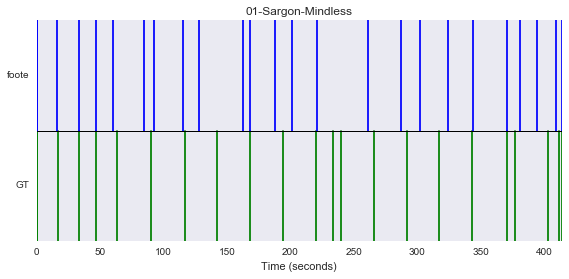

In [5]:
# Try one of these boundary algorithms and print results
boundaries, labels = msaf.process(audio_file, boundaries_id="foote", plot=True)

In [6]:
# Let's check all the structural grouping (label) algorithms available
print(msaf.get_all_label_algorithms())

['cnmf', 'fmc2d', 'scluster']


In [7]:
# Try one of these label algorithms
boundaries, labels = msaf.process(audio_file, boundaries_id="foote", labels_id="fmc2d")
print(boundaries)
print(labels)

[   0.            0.41795918   16.20752834   33.15809524   46.85786848
   60.37188209   84.56707483   92.27609977  115.26385488  127.80263039
  162.63256236  168.39111111  188.08163265  201.13124717  220.91464853
  261.45668934  287.64879819  302.27736961  324.7078458   343.88752834
  370.6369161   380.76081633  394.87854875  409.87863946  414.14530612]
[6, 5, 3, 5, 3, 3, 3, 5, 1, 5, 3, 2, 3, 5, 4, 5, 0, 2, 2, 5, 3, 3, 5, 6]


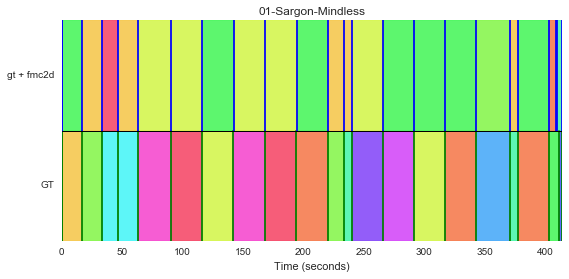

In [8]:
# If available, you can use previously annotated boundaries and a specific labels algorithm
# Set plot = True to plot the results
boundaries, labels = msaf.process(audio_file, boundaries_id="gt", 
                                  labels_id="fmc2d", plot=True)

### Using different Features ###

Some algorithms allow the input of different type of features (e.g., harmonic, timbral). In this section we show how we can input different features to MSAF.

In [9]:
# Let's check what available features are there in MSAF
print(msaf.AVAILABLE_FEATS)

['hpcp', 'mfcc', 'cqt', 'tonnetz']


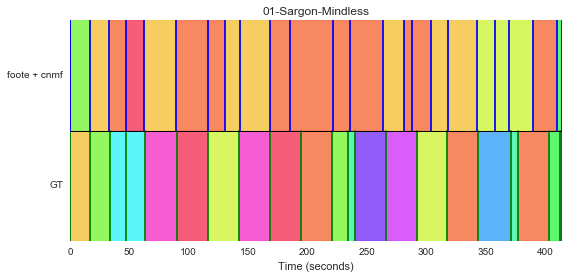

In [10]:
# Segment the file using the Foote method for boundaries, C-NMF method for labels, and MFCC features
boundaries, labels = msaf.process(audio_file, feature="mfcc", boundaries_id="foote", 
                                  labels_id="cnmf", plot=True)

### Evaluate Results ###

The results can be evaluated as long as there is an existing file containing reference annotations. The results are stored in a pandas DataFrame. MSAF has to run these algorithms (using `msaf.process` described above) before being able to evaluate its results.

In [11]:
# Evaluate the results. It returns a pandas data frame.
evaluations = msaf.eval.process(audio_file, boundaries_id="foote", labels_id="fmc2d")
IPython.display.display(evaluations)

,D,DevE2R,DevR2E,DevtE2R,DevtR2E,HitRate_0.5F,HitRate_0.5P,HitRate_0.5R,HitRate_3F,HitRate_3P,...,HitRate_t3P,HitRate_t3R,PWF,PWP,PWR,Sf,So,Su,ds_name,track_id
0,0.441305,2.11982,2.113595,3.03014,2.57498,0.326531,0.32,0.333333,0.530612,0.52,...,0.478261,0.5,0.243714,0.169481,0.433661,0.433443,0.578471,0.346558,01-Sargon-Mindless.jams,01-Sargon-Mindless


### Explore Algorithm Parameters ###

Now let's modify the configuration of one of the files, and modify it to see how different the results are.
We will use Widgets, which will become handy here.

In [12]:
# First, check which are foote's algorithm parameters:
print(msaf.algorithms.foote.config)

{'m_median': 12, 'L_peaks': 64, 'M_gaussian': 66}


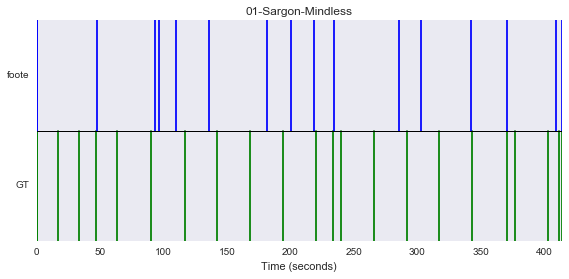

,D,DevE2R,DevR2E,DevtE2R,DevtR2E,HitRate_0.5F,HitRate_0.5P,HitRate_0.5R,HitRate_3F,HitRate_3P,HitRate_3R,HitRate_t0.5F,HitRate_t0.5P,HitRate_t0.5R,HitRate_t3F,HitRate_t3P,HitRate_t3R,ds_name,track_id
0,0.432536,2.531555,5.93854,4.365215,6.190105,0.238095,0.277778,0.208333,0.47619,0.555556,0.416667,0.157895,0.1875,0.136364,0.421053,0.5,0.363636,01-Sargon-Mindless.jams,01-Sargon-Mindless


In [13]:
# play around with IPython.Widgets
from ipywidgets import interact

# Obtain the default configuration
bid = "foote"  # Boundaries ID
lid = None     # Labels ID
feature = "hpcp"
config = msaf.io.get_configuration(feature, annot_beats=False, framesync=False, 
                                   boundaries_id=bid, labels_id=lid)

# Sweep M_gaussian parameters
@interact(M_gaussian=(50, 500, 25))
def _run_msaf(M_gaussian):
    # Set the configuration
    config["M_gaussian"] = M_gaussian
    
    # Segment the file using the Foote method, and Pitch Class Profiles for the features
    results = msaf.process(audio_file, feature=feature, boundaries_id=bid, 
                           config=config, plot=True)

    # Evaluate the results. It returns a pandas data frame.
    evaluations = msaf.eval.process(audio_file, feature=feature, boundaries_id=bid,
                                    config=config)
    IPython.display.display(evaluations)

## Collection Mode ##

MSAF is able to run and evaluate mutliple files using multi-threading. In this section we show this functionality.

In [14]:
dataset = "../datasets/Sargon/"
reload(msaf.input_output)
results = msaf.process(dataset, n_jobs=1, boundaries_id="foote")

In [15]:
# Evaluate in collection mode
evaluations = msaf.eval.process(dataset, n_jobs=4, boundaries_id="foote")
IPython.display.display(evaluations)

,D,DevE2R,DevR2E,DevtE2R,DevtR2E,HitRate_0.5F,HitRate_0.5P,HitRate_0.5R,HitRate_3F,HitRate_3P,HitRate_3R,HitRate_t0.5F,HitRate_t0.5P,HitRate_t0.5R,HitRate_t3F,HitRate_t3P,HitRate_t3R,ds_name,track_id
0,0.441305,2.119820,2.113595,3.03014,2.574980,0.326531,0.320000,0.333333,0.530612,0.520000,0.541667,0.266667,0.260870,0.272727,0.488889,0.478261,0.500000,01-Sargon-Mindless.jams,01-Sargon-Mindless
1,0.437517,1.465760,1.866960,1.58991,2.525040,0.177778,0.200000,0.160000,0.622222,0.700000,0.560000,0.097561,0.111111,0.086957,0.585366,0.666667,0.521739,02-Sargon-Shattered World.jams,02-Sargon-Shattered World
2,0.448502,1.406305,1.538855,1.44924,1.622175,0.200000,0.227273,0.178571,0.760000,0.863636,0.678571,0.130435,0.150000,0.115385,0.739130,0.850000,0.653846,03-Sargon-Waiting For Silence.jams,03-Sargon-Waiting For Silence
3,0.319123,0.783670,0.741630,0.87437,0.767820,0.413223,0.409836,0.416667,0.743802,0.737705,0.750000,0.393162,0.389831,0.396552,0.735043,0.728814,0.741379,04-Sargon-The Curse Of Akkad.jams,04-Sargon-The Curse Of Akkad
